In [8]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rd
import cv2
import aligner as temp_a
from aligner import Aligner
from importlib import reload
reload(temp_a)


<module 'aligner' from 'd:\\OneDrive - Instituto Superior de Engenharia de Lisboa\\Mestrado\\Semestre 2\\VARM\\P1\\Face-Detection-Recognition-main\\aligner.py'>

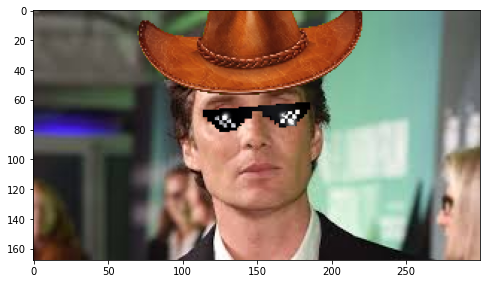

In [10]:
example = cv2.imread('cillian/cillian08.jpg')
hat = cv2.imread('objects/cowboy.jpg')
glasses = cv2.imread('objects/glasses.jpg')

# Hat eye center
hat_left_eye_center = (580, 560)
hat_right_eye_center = (740, 560)

# Glasses eye center
glasses_left_eye_center = (410, 350)
glasses_right_eye_center = (870, 350)

dic_objects = {'hat': hat, 'glasses': glasses}
dic_left_eye_center = {'hat': (580, 560), 'glasses': (410, 350)}
dic_right_eye_center = {'hat': (740, 560), 'glasses': (870, 350)}


def addVirtualObject(face, objects, eye_scale_factor=1.1, eye_min_neighbors=6):
    a = Aligner(eye_scale_factor=eye_scale_factor,
                eye_min_neighbors=eye_min_neighbors)
    final = face
    for object in objects:
        object_normalized = a.alignObjectToFace(
            dic_objects[object], face, dic_left_eye_center[object], dic_right_eye_center[object])
        if (object_normalized is None):
            continue
        # convert to hsv
        object_normalized_hsv = cv2.cvtColor(
            object_normalized, cv2.COLOR_BGR2HSV)

        # mask of green (36,25,25) ~ (86, 255,255)
        object_normalized_mask = cv2.inRange(
            object_normalized_hsv, (36, 25, 25), (86, 255, 255)) / 255

        # convert to rgb array of ints
        object_normalized_mask = np.array(np.ones(
            (object_normalized_mask.shape[0], object_normalized_mask.shape[1], 3)) * object_normalized_mask[:, :, None], dtype=int)

        # compute chroma key
        final = np.multiply(final, object_normalized_mask) + np.multiply(
            object_normalized, np.logical_not(object_normalized_mask))
    return np.array(final, dtype=np.uint8)


plt.figure(figsize=(8, 10))
plt.imshow(addVirtualObject(example, ['hat', 'glasses'], 1.05, 3)[:, :, ::-1])


In [ ]:
def findEyes(image):
    a = Aligner(eye_scale_factor=1.1, eye_min_neighbors=6)
    faces = a.cutFaces(image)
    if (len(faces) < 1):
        return None
    face, x, y = faces[0]
    eyes = a.findEyes(face)
    if (len(eyes) < 2):
        return None
    for eye in eyes:
        xe, ye, w, h = eye
        xe += x
        ye += y
        cv2.rectangle(image, (xe, ye), (xe + w, ye + h), (0, 0, 255), 2)


cv2.namedWindow("preview")
cam = cv2.VideoCapture(0)

while True:
    rval, frame = cam.read()
    frame = addVirtualObject(frame, ['hat', 'glasses'])
    # findEyes(frame)
    cv2.imshow("preview", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):  # Exit with 'q'
        break

cam.release()
cv2.destroyAllWindows()
